# Projeto Módulo 09 - Credit Card Fraud

Fonte: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

Professores: Patrícia Bongiovanni Catandi e Thiago Kuma

Integrantes: 

Caio Horita Moherdaui

Carlos Eduardo Gomes

Diego Delfino de Araujo

Leonardo Kerkhoff de Morais


### Variáveis

distancefromhome - the distance from home where the transaction happened.

distancefromlast_transaction - the distance from last transaction happened.

ratiotomedianpurchaseprice - Ratio of purchased price transaction to median purchase price.

repeat_retailer - Is the transaction happened from same retailer.

used_chip - Is the transaction through chip (credit card).

usedpinnumber - Is the transaction happened by using PIN number.

online_order - Is the transaction an online order.

fraud - Is the transaction fraudulent.


# ANÁLISE INICIAL

Iniciamos importando os pacotes necessários:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.options.display.float_format= "{:,.2f}".format
pd.set_option("display.float_format", lambda x: "%.3f" % x)
np.set_printoptions(suppress=True, precision=3)

# !pip install -q scikit-plot
# !pip install imbalanced-learn==0.9.0
# !pip show imbalanced-learn
# !pip install pandas_profiling


Importamos então o dataset utilizado e observamos a disposição das colunas e dos dados:

In [2]:
# Importar o dataset
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.878,0.311,1.946,1.000,1.000,0.000,0.000,0.000
1,10.830,0.176,1.294,1.000,0.000,0.000,0.000,0.000
2,5.091,0.805,0.428,1.000,0.000,0.000,1.000,0.000
3,2.248,5.600,0.363,1.000,1.000,0.000,1.000,0.000
4,44.191,0.566,2.223,1.000,1.000,0.000,1.000,0.000


In [3]:
# Verificando o tipo dos dados.
df.info()
# Verificamos que são do tipo númerico.
# Porém, alguns dados são categóricos: repeat_retailer, used_chip, 
#                                      used_pin_number, online_order, fraud.
# Variáveis numéricas: distance_from_home, distance_from_last_transaction,
#                      ratio_to_median_purchase_price.
# Percebe-se também que não há dados nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000
mean,26.629,5.037,1.824,0.882,0.350,0.101,0.651,0.087
std,65.391,25.843,2.800,0.323,0.477,0.301,0.477,0.282
min,0.005,0.000,0.004,0.000,0.000,0.000,0.000,0.000
25%,3.878,0.297,0.476,1.000,0.000,0.000,0.000,0.000
50%,9.968,0.999,0.998,1.000,0.000,0.000,1.000,0.000
75%,25.744,3.356,2.096,1.000,1.000,0.000,1.000,0.000
max,10632.724,11851.105,267.803,1.000,1.000,1.000,1.000,1.000


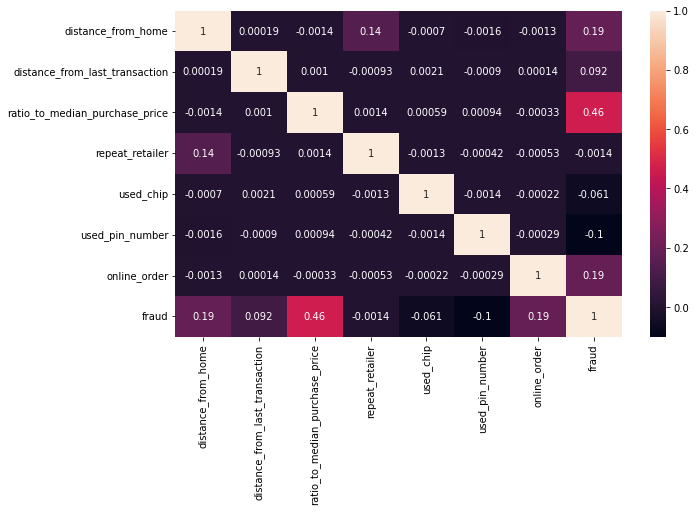

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [6]:
# Calculando a porcentagem de amostra em cada classe
df.fraud.value_counts(normalize=True)*100

0.000   91.260
1.000    8.740
Name: fraud, dtype: float64

É então realizado o Split dos dados, para evitar qualquer possibilidade de data leakage:

In [7]:
X = df.drop(["fraud"], axis=1)       # Variáveis independentes (features)
y = df[["fraud"]]                    # Variável dependente / target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify=y)
print("Tamanho do treino: ", X_train.shape)
print("Tamanho do teste: ", X_test.shape)

Tamanho do treino:  (700000, 7)
Tamanho do teste:  (300000, 7)


Fazemos uma primeira análise dos dados de treino plotando a distribuição do target:

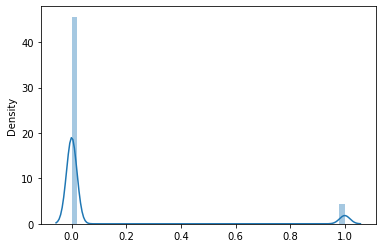

Skewness: 2.921829
Kurtosis: 6.537103


In [8]:
sns.distplot(y_train)
plt.show()
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

Percebe-se que há um desbalanceamento aparente entre as classes do target. Isso pode ser tratado com os métodos apresentados durante a modelagem, para comparação. Vejamos como as features se comportarm com um pairplot:

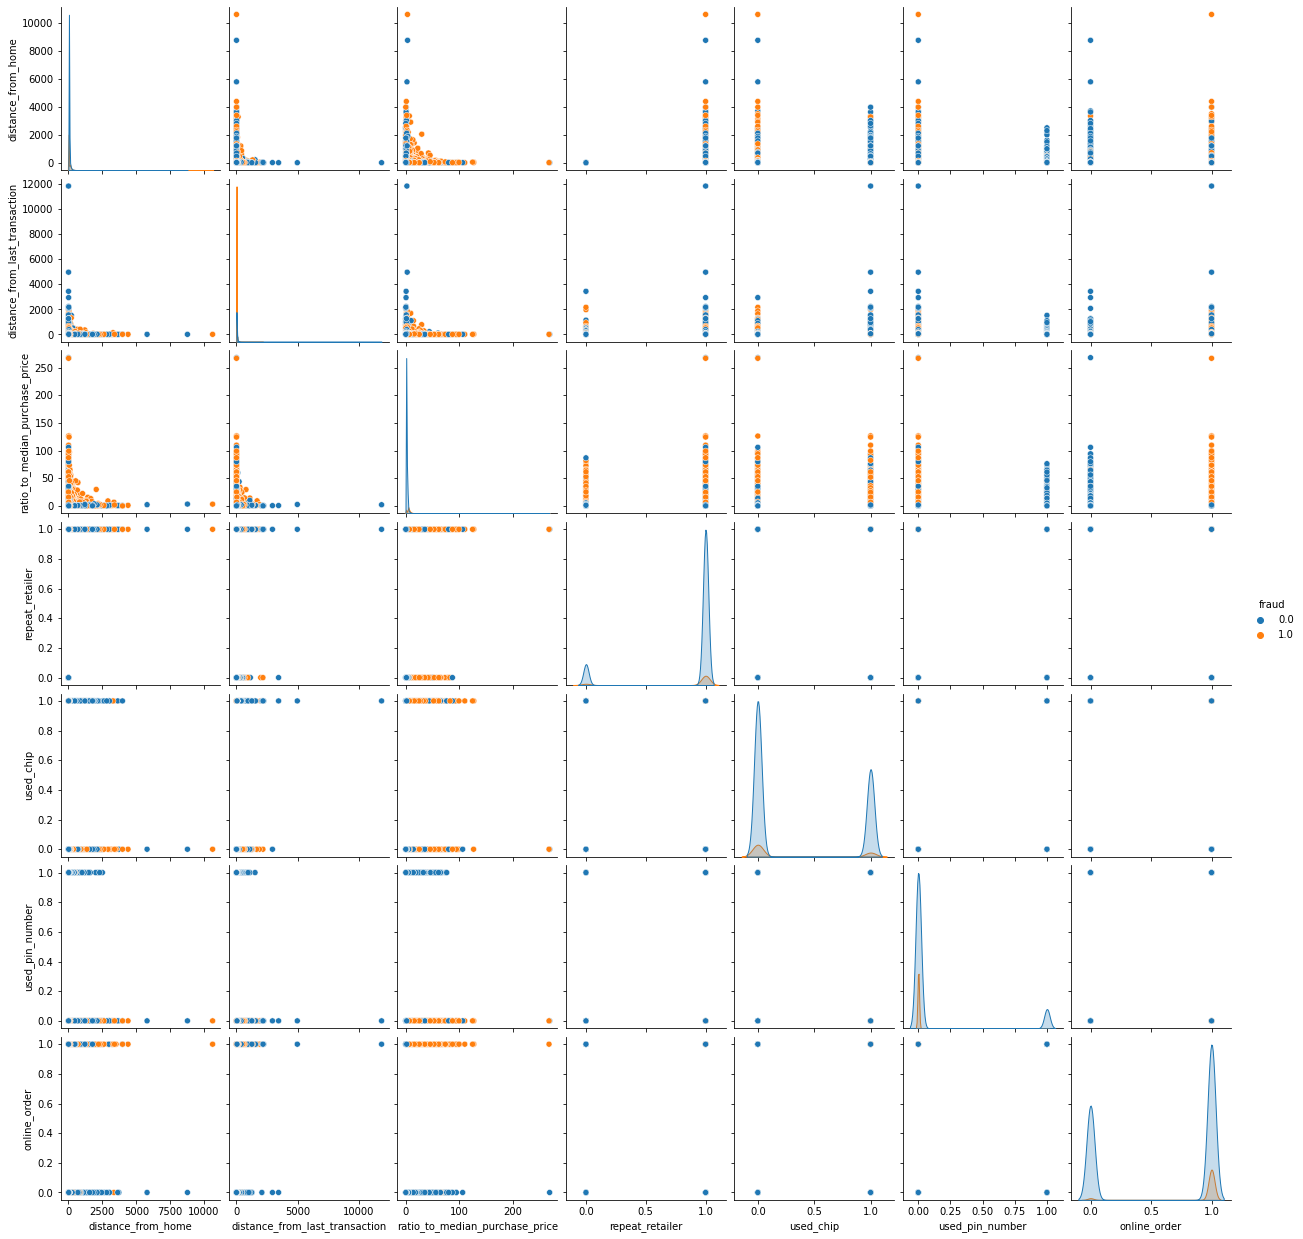

In [9]:
sns.pairplot(data=pd.concat([X_train, y_train], axis=1), hue="fraud")

# DESENVOLVIMENTO

Separamos então as colunas numéricas contínuas, para posterior tratamento caso necessário:

In [10]:
num_cols = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']

Declaramos as variáveis possíveis, para uso nas funções de modelagem:

In [11]:
#K-Fold:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Modelos possíveis:
models = {
        'logit' : LogisticRegression(random_state=42),
        'knn' : KNeighborsClassifier(),
        'tree' : DecisionTreeClassifier(random_state=42),
        'rf' : RandomForestClassifier(random_state=42)}

#Hiperparâmetros possíveis:
params = {
    'logit' : {
        'C': [0.01, 1.0, 10],
        'class_weight': [None, 'balanced'],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
        },
    'knn' : {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'p': [1, 2],
        'weights': ['uniform', 'distance']
    },
    'tree' : {
        'criterion': ['entropy', 'gini'],
        'max_depth': [2,5,10,15,20],
        'min_samples_leaf': [2,5,10,15],
        'min_samples_split': [2,5,10,15],
    },
    'rf' : {
        'n_estimators': [25, 50, 100, 200],
        'criterion': ['entropy', 'gini'],
        'max_depth': [2,5,10,15,20],
        'min_samples_leaf': [2,5,10,15],
        'min_samples_split': [2,5,10,15],
    }}
    
#scalers possíveis:
ln_scaler = ColumnTransformer(transformers=[('log', FunctionTransformer(np.log), num_cols)])
mms = MinMaxScaler()

#oversamplers possíveis:
random_oversampler = RandomOverSampler(sampling_strategy = 0.15, random_state = 42)
smote = SMOTE(sampling_strategy = 0.15, random_state = 42)
smotenc = SMOTENC(categorical_features = [3,4,5,6] , sampling_strategy = 0.15, random_state = 42)
adasyn = ADASYN(sampling_strategy = 0.15, random_state = 42)

#undersamplers possíveis:
rus = RandomUnderSampler(sampling_strategy = 0.33, random_state = 42)

Para os estimadores, serão comparados KNN, Regressão logística, árvore de decisão e Random Forest, com e sem tuning em seus principais hiperparâmetros. Como Scalers, serão utilizados o MinMaxScaler e um Column transformer que aplica escala logarítmica sobre os dados das colunas contínuas. No caso de oversamplers, serão declarados o Random Oversampler, Smote, Smotenc e Adasyn, e como undersampler será utilizado sempre o modelo randômico, para evitar qualquer viés nos dados.

É declarada então uma função de execução genérica para nosso modelo, que permite a seleção de quais estimadores e tratamentos aplicar sem a necessidade da repetição do código para cada execução:

In [12]:
def results (model, y_test, y_pred, grid=None, balance=None):

    cm = confusion_matrix(y_test,y_pred)

    #plota os resultados para os casos com grid search
    if grid:

        #plota os resultados para os casos com grid search e balanceamento
        if balance:
            print('Melhores parâmetros para o modelo {} com balanceamento por {} e undersampling: \n {}'.format(model,balance,grid.best_params_))
            print('RESULTADOS MODELO {}'.format(model.upper()))
            print(classification_report(y_test, y_pred))
            ConfusionMatrixDisplay(cm).plot()
            plt.show()
            return classification_report(y_test, y_pred, output_dict=True)

        #plota os resultados para os casos com grid search mas sem balanceamento
        print('Melhores parâmetros para o modelo {} sem balanceamento de classes: \n {}'.format(model,grid.best_params_))
        print('RESULTADOS MODELO {}'.format(model.upper()))
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay(cm).plot()
        plt.show()
        return classification_report(y_test, y_pred, output_dict=True)

    #plota os resultados sem grid search com balanceamento de classes
    if balance:
        print('RESULTADOS MODELO {} DEFAULT COM BALANCEAMENTO POR {} E UNDERSAMPLING'.format(model.upper(),balance))
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay(cm).plot()
        plt.show()
        return classification_report(y_test, y_pred, output_dict=True)
        
    #plota os resultados sem grid search nem balanceamento de classes
    print('RESULTADOS MODELO {} DEFAULT SEM BALANCEAMENTO DE CLASSES'.format(model.upper()))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    return classification_report(y_test, y_pred, output_dict=True)

def solver (X_train, X_test, y_train, y_test, model, model_name, grid=False, oversampler=None, scaler=None):

    if grid:
    
        if oversampler:

            if scaler:
                #modelo com grid, com oversampler e com scaler
                pipeline = Pipeline([
                    ('oversampling' , oversampler),
                    ('undersampling' , rus),
                    ('scaler' , scaler),
                    ('estimator' , model)])
                grid = GridSearchCV(pipeline,params[model_name],n_jobs=-1,cv=fold)
                grid.fit(X_train,y_train)
                y_pred = grid.predict(X_test)
                return results(model_name,y_test,y_pred,grid,oversampler)
            #modelo com grid, com oversampler e sem scaler
            pipeline = Pipeline([
                ('oversampling' , oversampler),
                ('undersampling' , rus),
                ('estimator' , model)])
            grid = GridSearchCV(pipeline,params[model_name],n_jobs=-1,cv=fold)
            grid.fit(X_train,y_train)
            y_pred = grid.predict(X_test)
            return results(model_name,y_test,y_pred,grid,oversampler)
            
        if scaler:
            #modelo com grid, sem oversampler e com scaler
            pipeline = Pipeline([
                ('scaler' , scaler,)
                ('estimator' , model)])
            grid = GridSearchCV(pipeline,params[model_name],n_jobs=-1,cv=fold)
            grid.fit(X_train,y_train)
            y_pred = grid.predict(X_test)
            return results(model_name,y_test,y_pred,grid)
        #modelo com grid, sem oversampler e sem scaler
        grid = GridSearchCV(model,params[model_name],n_jobs=-1,cv=fold)
        grid.fit(X_train,y_train)
        y_pred = grid.predict(X_test)
        return results(model_name,y_test,y_pred,grid)

    if oversampler:

        if scaler:
            #modelo sem grid, com oversampler e com scaler
            pipeline = Pipeline([
                ('oversampling' , oversampler),
                ('undersampling' , rus),
                ('scaler' , scaler),
                ('estimator' , model)])
            pipeline.fit(X_train,y_train)
            y_pred = pipeline.predict(X_test)
            return results(model_name,y_test,y_pred,balance=oversampler)
        #modelo sem grid, com oversampler e sem scaler
        pipeline = Pipeline([
            ('oversampling' , oversampler),
            ('undersampling' , rus),
            ('estimator' , model)])
        pipeline.fit(X_train,y_train)
        y_pred = pipeline.predict(X_test)
        return results(model_name,y_test,y_pred,balance=oversampler)

    if scaler:
        #modelo sem grid, sem oversampler e com scaler 
        pipeline = Pipeline([
            ('scaler' , scaler),
            ('estimator' , model)
            ])
        pipeline.fit(X_train,y_train)
        y_pred = pipeline.predict(X_test)
        return results(model_name,y_test,y_pred)

    #modelo sem grid search nem tratamentos:
    model.fit(X_train,y_train) 
    y_pred = model.predict(X_test)
    return results (model_name, y_test, y_pred)

Vamos declarar também dicionários vazios para cada caso, que serão populados com as métricas para cada estimador:

In [13]:
dict_default = {}
dict_default_smote = {}
dict_default_smotenc = {}
dict_default_adasyn = {}
dict_default_mms = {}
dict_default_ln = {}
dict_default_balance_scaler = {}
dict_grid_balance_scaler = {}

Declarados os dados necessários, vejamos como se comporta nosso modelo com cada estimador em default, sem qualquer tipo de tratamento: 

# RESULTADOS

RESULTADOS MODELO LOGIT DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    273779
         1.0       0.90      0.57      0.70     26221

    accuracy                           0.96    300000
   macro avg       0.93      0.78      0.84    300000
weighted avg       0.95      0.96      0.95    300000



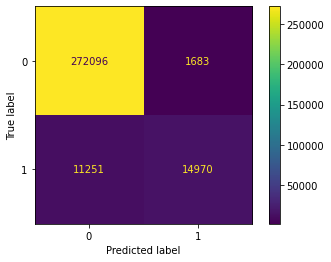

RESULTADOS MODELO KNN DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    273779
         1.0       0.89      0.92      0.91     26221

    accuracy                           0.98    300000
   macro avg       0.94      0.96      0.95    300000
weighted avg       0.98      0.98      0.98    300000



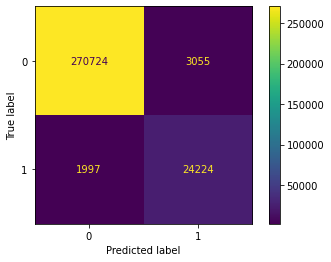

RESULTADOS MODELO TREE DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



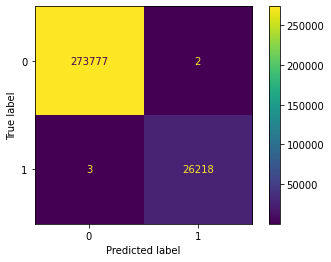

RESULTADOS MODELO RF DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



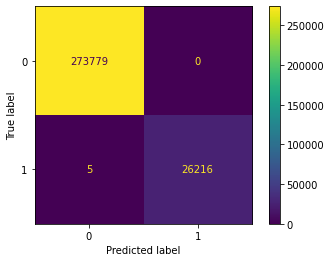

In [14]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name)
    dict_default[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

Vemos que já de início temos resultados quase perfeitos em alguns modelos, o que pode se dar pela qualidade dos dados sintéticos da base, já preparada para a aplicação de modelos. Vejamos como os resultados variam com o uso de cada balanceamento de classe:

## BALANCEAMENTO

* Smote:

RESULTADOS MODELO LOGIT DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    273779
         1.0       0.73      0.84      0.78     26221

    accuracy                           0.96    300000
   macro avg       0.86      0.91      0.88    300000
weighted avg       0.96      0.96      0.96    300000



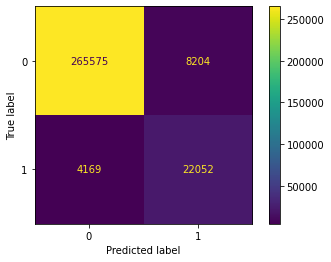

RESULTADOS MODELO KNN DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    273779
         1.0       0.75      0.98      0.85     26221

    accuracy                           0.97    300000
   macro avg       0.88      0.97      0.92    300000
weighted avg       0.98      0.97      0.97    300000



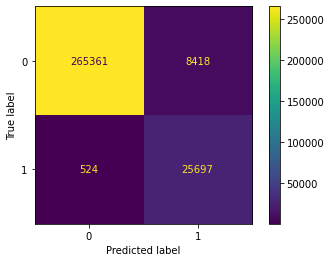

RESULTADOS MODELO TREE DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



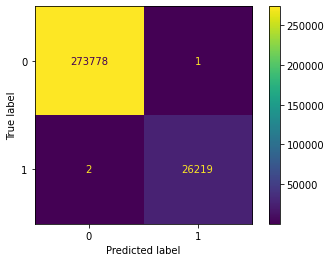

RESULTADOS MODELO RF DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



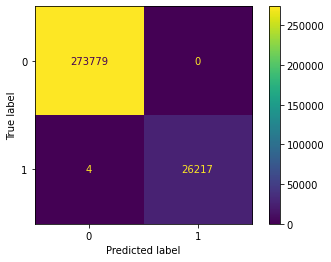

In [15]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,oversampler=smote)
    dict_default_smote[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

* Smotenc

RESULTADOS MODELO LOGIT DEFAULT COM BALANCEAMENTO POR SMOTENC(categorical_features=[3, 4, 5, 6], random_state=42,
        sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    273779
         1.0       0.75      0.85      0.79     26221

    accuracy                           0.96    300000
   macro avg       0.87      0.91      0.89    300000
weighted avg       0.96      0.96      0.96    300000



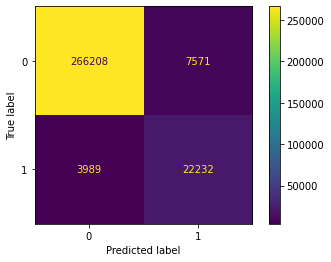

RESULTADOS MODELO KNN DEFAULT COM BALANCEAMENTO POR SMOTENC(categorical_features=[3, 4, 5, 6], random_state=42,
        sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    273779
         1.0       0.75      0.98      0.85     26221

    accuracy                           0.97    300000
   macro avg       0.88      0.97      0.92    300000
weighted avg       0.98      0.97      0.97    300000



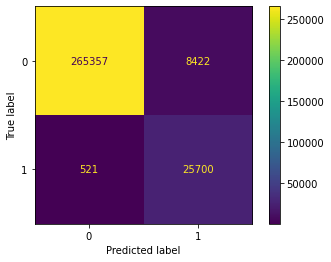

RESULTADOS MODELO TREE DEFAULT COM BALANCEAMENTO POR SMOTENC(categorical_features=[3, 4, 5, 6], random_state=42,
        sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



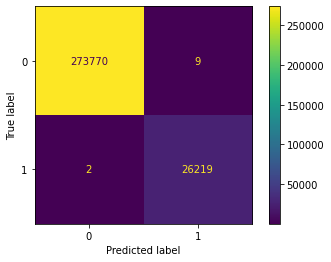

RESULTADOS MODELO RF DEFAULT COM BALANCEAMENTO POR SMOTENC(categorical_features=[3, 4, 5, 6], random_state=42,
        sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



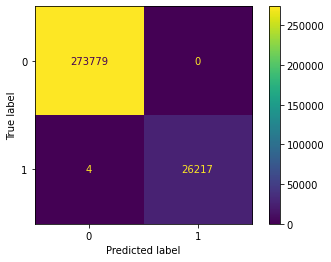

In [16]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,oversampler=smotenc)
    dict_default_smotenc[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

* Adasyn:

RESULTADOS MODELO LOGIT DEFAULT COM BALANCEAMENTO POR ADASYN(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    273779
         1.0       0.76      0.84      0.80     26221

    accuracy                           0.96    300000
   macro avg       0.87      0.91      0.89    300000
weighted avg       0.96      0.96      0.96    300000



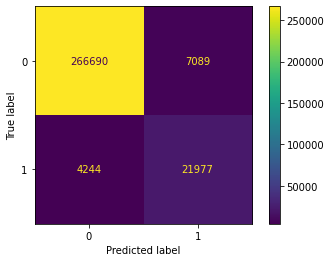

RESULTADOS MODELO KNN DEFAULT COM BALANCEAMENTO POR ADASYN(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    273779
         1.0       0.73      0.99      0.84     26221

    accuracy                           0.97    300000
   macro avg       0.87      0.98      0.91    300000
weighted avg       0.98      0.97      0.97    300000



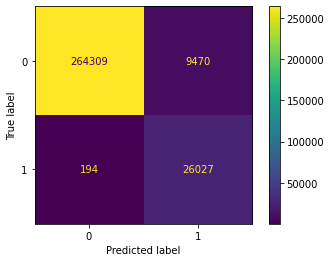

RESULTADOS MODELO TREE DEFAULT COM BALANCEAMENTO POR ADASYN(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



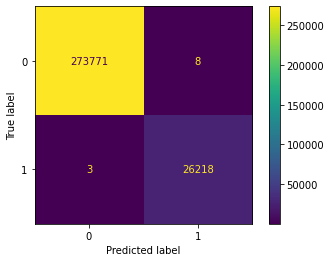

RESULTADOS MODELO RF DEFAULT COM BALANCEAMENTO POR ADASYN(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



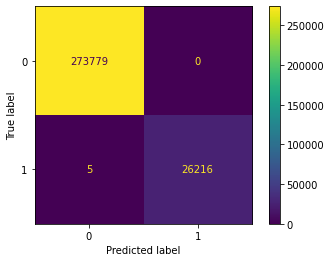

In [17]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,oversampler=adasyn)
    dict_default_adasyn[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

Percebe-se pelos resultados que todos os métodos de balanceamento possuem resultado semelhante na melhoria dos modelos. Seguiremos então com o método SMOTE, por sua rápida execução. Estudemos agora o efeito dos scalers no modelo comum:

## SCALER

* MinMaxScaler:

RESULTADOS MODELO LOGIT DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    273779
         1.0       0.92      0.39      0.55     26221

    accuracy                           0.94    300000
   macro avg       0.93      0.69      0.76    300000
weighted avg       0.94      0.94      0.93    300000



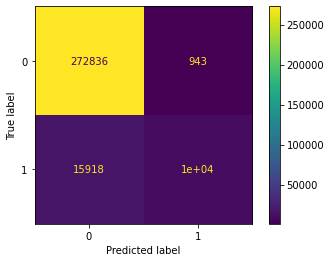

RESULTADOS MODELO KNN DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      0.99      0.99     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



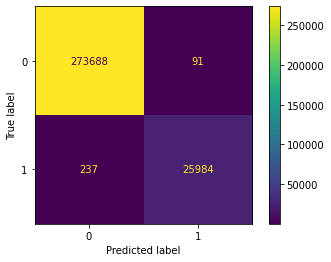

RESULTADOS MODELO TREE DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



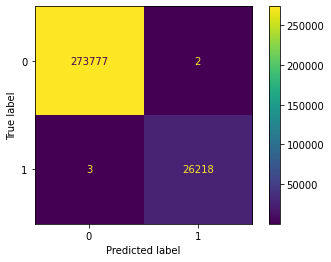

RESULTADOS MODELO RF DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



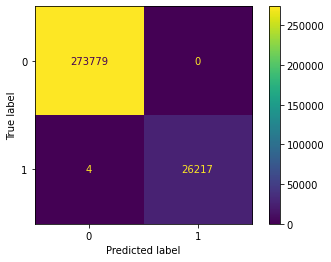

In [18]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,scaler=mms)
    dict_default_mms[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

* Logarítmico:

RESULTADOS MODELO LOGIT DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    273779
         1.0       0.64      0.25      0.36     26221

    accuracy                           0.92    300000
   macro avg       0.79      0.62      0.66    300000
weighted avg       0.91      0.92      0.91    300000



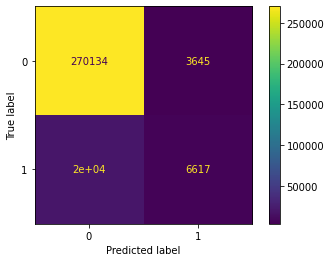

RESULTADOS MODELO KNN DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    273779
         1.0       0.60      0.60      0.60     26221

    accuracy                           0.93    300000
   macro avg       0.78      0.78      0.78    300000
weighted avg       0.93      0.93      0.93    300000



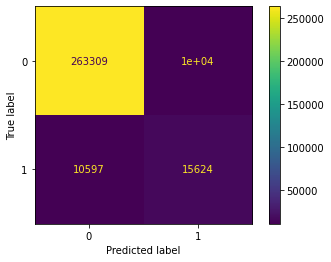

RESULTADOS MODELO TREE DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    273779
         1.0       0.58      0.58      0.58     26221

    accuracy                           0.93    300000
   macro avg       0.77      0.77      0.77    300000
weighted avg       0.93      0.93      0.93    300000



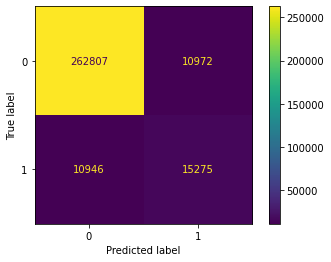

RESULTADOS MODELO RF DEFAULT SEM BALANCEAMENTO DE CLASSES
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    273779
         1.0       0.61      0.64      0.63     26221

    accuracy                           0.93    300000
   macro avg       0.79      0.80      0.80    300000
weighted avg       0.93      0.93      0.93    300000



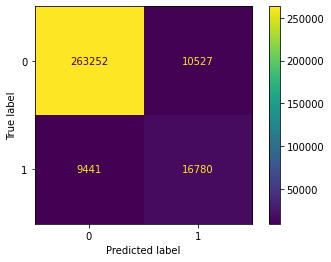

In [19]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,scaler=ln_scaler)
    dict_default_ln[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

Percebe-se que o melhor resultado foi alcançado utilizando-se o minmaxscaler. Façamos então a estimativa utilizando o Smote combinado com o minmaxscaler:

## BALANCEAMENTO + SCALER

RESULTADOS MODELO LOGIT DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98    273779
         1.0       0.82      0.73      0.77     26221

    accuracy                           0.96    300000
   macro avg       0.90      0.86      0.88    300000
weighted avg       0.96      0.96      0.96    300000



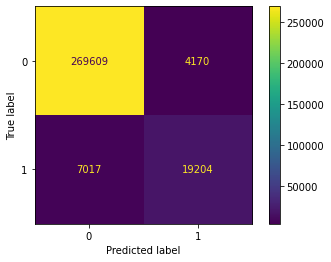

RESULTADOS MODELO KNN DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       0.99      1.00      0.99     26221

    accuracy                           1.00    300000
   macro avg       0.99      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



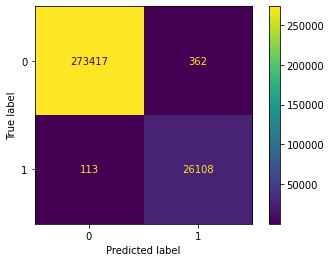

RESULTADOS MODELO TREE DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



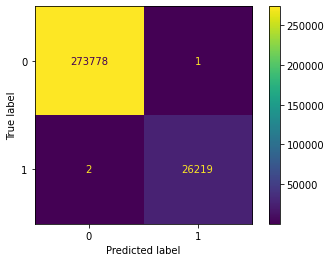

RESULTADOS MODELO RF DEFAULT COM BALANCEAMENTO POR SMOTE(random_state=42, sampling_strategy=0.15) E UNDERSAMPLING
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



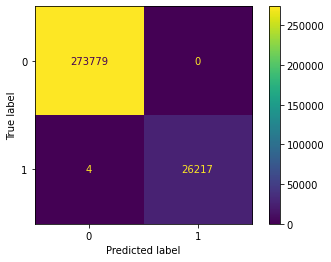

In [20]:
for model_name, model in models.items():
    dict = solver(X_train,X_test,y_train,y_test,model,model_name,oversampler = smote,scaler=mms)
    dict_default_balance_scaler[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

Ao passo que o scaler piora os resultados da regressão logística, há um grande ganho nos resultados do knn. Para finalizar, vamos aplicar o grid_search para verificar quais os melhores hiperparâmetros para nosso modelo e qual o resultado do tuning:

## GRID SEARCH

In [21]:
#for model_name, model in models.items():
#    dict = solver(X_train,X_test,y_train,y_test,model,model_name,oversampler = smote,scaler=mms,grid=True)
#   dict_grid_balance_scaler[model_name] = [dict['1.0']['precision'],dict['1.0']['recall'],dict['1.0']['f1-score'],dict['accuracy']]

## RESULTADOS

Os dados são então transformados em dataframes e concatenados para melhor visualização:

In [33]:
pd_default = pd.DataFrame.from_dict(dict_default,orient='index')
pd_default.columns=pd.MultiIndex.from_product([['Default'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_smote = pd.DataFrame.from_dict(dict_default_smote,orient='index')
pd_default_smote.columns=pd.MultiIndex.from_product([['Balanceamento SMOTE'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_smotenc = pd.DataFrame.from_dict(dict_default_smotenc,orient='index')
pd_default_smotenc.columns=pd.MultiIndex.from_product([['Balanceamento SMOTENC'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_adasyn = pd.DataFrame.from_dict(dict_default_adasyn,orient='index')
pd_default_adasyn.columns=pd.MultiIndex.from_product([['Balanceamento ADASYN'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_mms = pd.DataFrame.from_dict(dict_default_mms,orient='index')
pd_default_mms.columns=pd.MultiIndex.from_product([['Scaler MMS'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_ln = pd.DataFrame.from_dict(dict_default_ln,orient='index')
pd_default_ln.columns=pd.MultiIndex.from_product([['Scaler Logarítmico'], ['Precision','Recall','F1-Score','Accuracy']])
pd_default_balance_scaler = pd.DataFrame.from_dict(dict_default_smote,orient='index')
pd_default_balance_scaler.columns=pd.MultiIndex.from_product([['SMOTE + MMS'], ['Precision','Recall','F1-Score','Accuracy']])

In [34]:
df_results = pd.concat([pd_default, pd_default_smote, pd_default_smotenc, pd_default_adasyn, pd_default_mms, pd_default_ln, pd_default_balance_scaler], axis=1)
df_results.to_excel('resultados.xlsx')

In [50]:
df_results

Default                               Balanceamento SMOTE            \
      Precision    Recall  F1-Score  Accuracy           Precision    Recall   
logit  0.898937  0.570916  0.698325  0.956887            0.728847  0.841005   
knn    0.888009  0.923840  0.905570  0.983160            0.753246  0.980016   
tree   0.999924  0.999886  0.999905  0.999983            0.999962  0.999924   
rf     1.000000  0.999809  0.999905  0.999983            1.000000  0.999847   

                          Balanceamento SMOTENC            ... Scaler MMS  \
       F1-Score  Accuracy             Precision    Recall  ...   F1-Score   
logit  0.780920  0.958757              0.745965  0.847870  ...   0.549977   
knn    0.851797  0.970193              0.753180  0.980130  ...   0.993728   
tree   0.999943  0.999990              0.999657  0.999924  ...   0.999905   
rf     0.999924  0.999987              1.000000  0.999847  ...   0.999924   

                Scaler Logarítmico                               SMOTE + MMS  \
       Accuracy          Precision    Recall  F1-Score  Accuracy   Precision   
logit  0.943797           0.644806  0.252355  0.362744  0.922503    0.728847   
knn    0.998907           0.598758  0.595858  0.597305  0.929777    0.753246   
tree   0.999983           0.581971  0.582548  0.582260  0.926940    0.999962   
rf     0.999987           0.614494  0.639945  0.626962  0.933440    1.000000   

                                     
         Recall  F1-Score  Accuracy  
logit  0.841005  0.780920  0.958757  
knn    0.980016  0.851797  0.970193  
tree   0.999924  0.999943  0.999990  
rf     0.999847  0.999924  0.999987  

[4 rows x 28 columns]

OBRIGADO!